# Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew.

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

<a name="datadictionary"></a>
### Data Dictionary

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

## Prep work

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

%matplotlib inline

### Import data

In [2]:
# ANSWER
titanic_csv_name = '../DATA/titanic_train.csv'
titanic = pd.read_csv(titanic_csv_name, index_col='PassengerId') #.set_index('PassengerID')


## Main Function

In [3]:
def titanic_logreg(df, feature_list):
    X = df[feature_list]
    y = df['Survived']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    logreg_model = LogisticRegression()
    logreg_model.fit(X_train, y_train)  # After fit is called, can get coefficents (.coef_) and intercept (.intercept_)
    
    training_score = logreg_model.score(X_train, y_train)
    test_score = logreg_model.score(X_test, y_test)
    
    training_predictions = logreg_model.predict(X_train)
    test_predictions = logreg_model.predict(X_test)

    training_confusion_matrix = metrics.confusion_matrix(y_train, training_predictions)
    test_confusion_matrix = metrics.confusion_matrix(y_test, test_predictions)

    print('Training')
    print('--------')
    print(f'Score: {training_score:7.4f}')
    print('Matrix:')
    print(training_confusion_matrix)
    print()
    print('Test')
    print('----')
    print(f'Score: {test_score:7.4f}')
    print('Matrix:')
    print(test_confusion_matrix)

    # ROC chart ----------------------------------------------------------------------------------------------------------------------
    
    # Generate the prediction values for each of the test observations using predict_proba() function rather than just predict (--> WHY?)
    preds = logreg_model.predict_proba(X_test)[:,1]
    # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    # Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = "lower right")
    plt.show()

## 1st pass: using `Pclass` and `parch`

Training
--------
Score:  0.6901
Matrix:
[[353  68]
 [139 108]]

Test
----
Score:  0.6682
Matrix:
[[105  23]
 [ 51  44]]


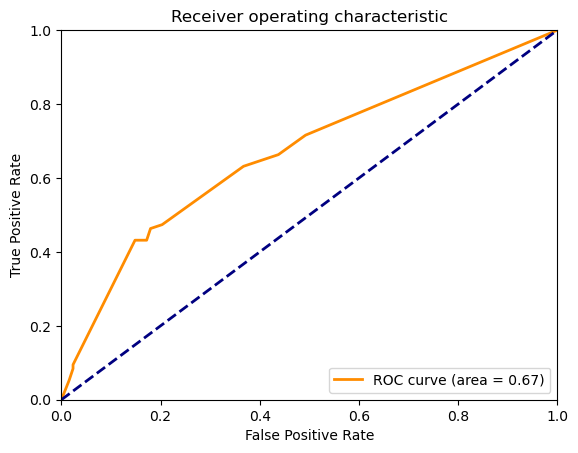

In [4]:
feature_cols = ['Pclass', 'Parch']
titanic_logreg(titanic, feature_cols)

## Add `Age`

⚠️ First impute null values: LogisticRegression cannot accept data with missing (`null`) values and will throw an error!

In [5]:
mean_age = titanic['Age'].mean()
titanic['Age'] = titanic['Age'].fillna(mean_age)

Training
--------
Score:  0.7171
Matrix:
[[363  58]
 [131 116]]

Test
----
Score:  0.6726
Matrix:
[[107  21]
 [ 52  43]]


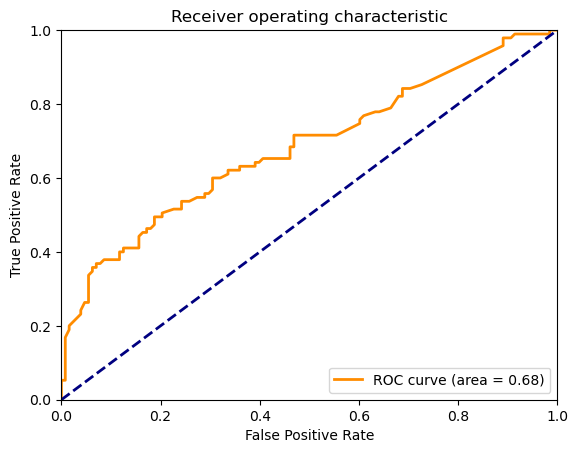

In [6]:
titanic_logreg(titanic, feature_cols + ['Age'])

## Include categorical predictors

Reimport the file to reset the Age column (undo our imputations)--we are going to using a different approach to imputing the age values: We are going to use the categories to stratify the data before doing the imputation.

Note: When using pandas `get_dummies()` method, the `prefix` argument is optional. It will by default use the original column name as the prefix.

In [7]:
titanic = pd.read_csv(titanic_csv_name, index_col='PassengerId')

titanic_with_dummies = pd.get_dummies(data = titanic, columns = ['Sex', 'Embarked', 'Pclass'])

for col_name in titanic_with_dummies:
    print(col_name)

Survived
Name
Age
SibSp
Parch
Ticket
Fare
Cabin
Sex_female
Sex_male
Embarked_C
Embarked_Q
Embarked_S
Pclass_1
Pclass_2
Pclass_3


Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [8]:
other_features = ["Parch", "Sex_male", "Pclass_1", "Pclass_2"]

titanic_with_dummies['Age'] = (
    titanic_with_dummies[other_features + ['Age']]
    .groupby(other_features)["Age"]
    .transform(lambda x: x.fillna(x.mean()))
    )

Now we can run the model

Training
--------
Score:  0.7979
Matrix:
[[362  59]
 [ 76 171]]

Test
----
Score:  0.7982
Matrix:
[[112  16]
 [ 29  66]]


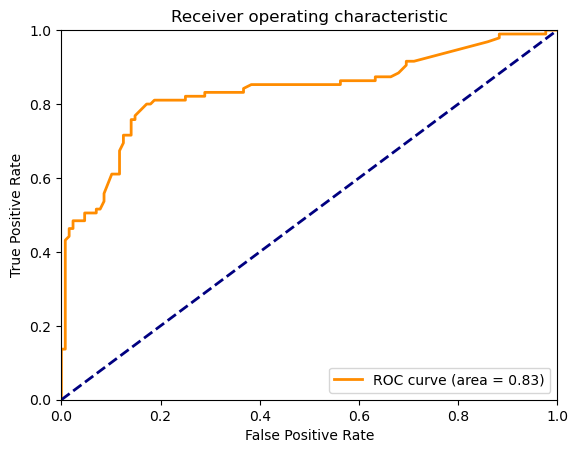

In [9]:
titanic_logreg(titanic_with_dummies, other_features + ['Age'])